In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import warnings
import sys
import matplotlib.pyplot as plt

In [3]:
sys.path.append('/home/mondzi259/Apna_Assignment/src/ml_auto/')

In [4]:
from custom_estimator import Estimator, scoring_metric
from encoding import FreqeuncyEncoding,TargetEncoding
from hyperopt_model_selection import HyperOptModelSelection,hp
from custom_fold_generator import KFold,GroupKFold,CustomFolds
from lightgbm import LGBMRegressor

In [5]:
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [7]:
DATA_DIR = '/home/mondzi259/Apna_Assignment/data/'

In [8]:
df = pd.read_excel(os.path.join(DATA_DIR,'data.xlsx'),sheet_name=0)
df.shape

(30000, 19)

In [9]:
df.drop('feebackgiven',axis=1,inplace=True)

In [10]:
data_dic = pd.read_excel(os.path.join(DATA_DIR,'data.xlsx'),sheet_name=1,header=None)

In [11]:
data_dic

,0,1,2,3
0,lead,A candidate who has interacted with HR on the ...,NaN,NaN
1,shift,night/ day,"0 - day, 1 - night",NaN
2,gender,f/m/all,"0 - male jobs, 1 - female , 2 - all",NaN
3,education,10th to PG,"ordinally placed, 10th being lowest and PG the...",NaN
4,created_on,job created date,Days since a fixed reference data,"For ex: if reference data was 1 Jan 2020,\njob..."
5,employer_type,key-account/ smb/ enterprise/ consultant/ NA,"most jobs are smb, followed by Key accounts, e...",NaN
6,applicant_location,candidate distance from job,"lower the value, lower the distance requirement",NaN
7,city,city,is masked,NaN
8,area,area,is masked,NaN
9,organization,company name,is masked,NaN


In [12]:
df.head()

,shift,gender,education,created_on,dow,employer_type,applicant_location,city,area,organization,deposit,category,english,num_openings,max_salary,min_salary,is_part_time,leads_per_opening
0,0.0,0.0,3.0,413.0,3.0,0.0,0.0,1.0,4119.0,31278.0,0.0,55.0,2.0,22.0,21000.0,NaN,0.0,0.090909
1,0.0,0.0,3.0,529.0,0.0,4.0,0.0,2.0,2017.0,32006.0,0.0,54.0,2.0,2.0,80000.0,NaN,0.0,31.500000
2,0.0,0.0,0.0,457.0,0.0,4.0,0.0,3.0,1500.0,32029.0,0.0,42.0,3.0,1.0,3500.0,NaN,1.0,9.000000
3,0.0,0.0,4.0,450.0,3.0,4.0,0.0,5.0,638.0,9925.0,0.0,60.0,4.0,4.0,11500.0,NaN,0.0,0.000000
4,0.0,0.0,0.0,480.0,0.0,1.0,0.0,2.0,4115.0,8400.0,0.0,16.0,3.0,25.0,25000.0,NaN,0.0,1.400000


### Target vs created_on

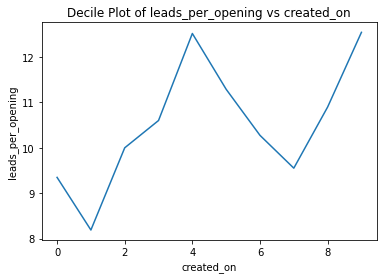

In [13]:
df.groupby(pd.qcut(df['created_on'],10,
                   duplicates='drop',labels=False))['leads_per_opening'].mean().plot()
plt.ylabel('leads_per_opening')
plt.title('Decile Plot of leads_per_opening vs created_on');

### 

In [14]:
num_cols = ['leads_per_opening','max_salary','min_salary','deposit','num_openings','created_on']
cat_cols = [i for i in df.columns.tolist() if i not in num_cols]
cat_ordinal_cols = ['applicant_location','english','education']
cat_non_ord_cols = [i for i in cat_cols if i not in cat_ordinal_cols]

In [15]:
cat_non_ord_cols,cat_ordinal_cols

(['shift',
  'gender',
  'dow',
  'employer_type',
  'city',
  'area',
  'organization',
  'category',
  'is_part_time'],
 ['applicant_location', 'english', 'education'])

In [16]:
df[cat_cols].nunique()

shift                     2
gender                    3
education                 6
dow                       7
employer_type             5
applicant_location        4
city                      7
area                   2740
organization          14886
category                 67
english                   4
is_part_time              2
dtype: int64

In [17]:
class FreqEnc:
    def __init__(self,cat_freq_cols):
        self.cat_freq_cols = cat_freq_cols
    def fit(self,df):
        self.freq_encoding_dict = {
                x: df[x].value_counts(1).to_dict() for x in self.cat_freq_cols
            }
    def transform(self,df):
        for col in self.cat_freq_cols:
            df[col+"_fe"] = df[col].map(self.freq_encoding_dict[col]).fillna(0)
        return df
    def fit_transform(self,df):
        self.fit(df)
        return self.transform(df)

In [18]:
df=df.sort_values('created_on').reset_index(drop=True)

In [19]:
df.shape

(30000, 18)

In [20]:
df['target'] = np.log1p(df.leads_per_opening)

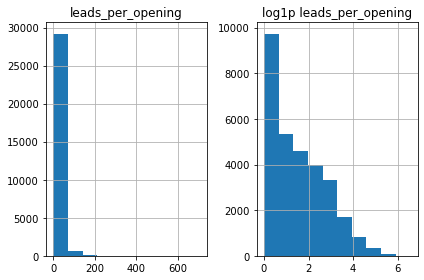

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
df.leads_per_opening.hist(ax=axes[0])
axes[0].set_title('leads_per_opening')
df.target.hist(ax=axes[1])
axes[1].set_title('log1p leads_per_opening')
plt.tight_layout()

In [22]:
df.target.describe()

count    30000.000000
mean         1.507317
std          1.264234
min          0.000000
25%          0.385158
50%          1.299283
75%          2.397895
max          6.559615
Name: target, dtype: float64

In [23]:
folds =[
    (df[(df.created_on<=df.created_on.quantile(0.7))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.7))&\
      (df.created_on<=df.created_on.quantile(0.8))].index.tolist()),
    
    (df[(df.created_on>=df.created_on.quantile(0.1))&\
      (df.created_on<=df.created_on.quantile(0.8))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.8))&\
      (df.created_on<=df.created_on.quantile(0.9))].index.tolist()),
    
    (df[(df.created_on>=df.created_on.quantile(0.2))&\
      (df.created_on<=df.created_on.quantile(0.9))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.9))&\
      (df.created_on<=df.created_on.quantile(1))].index.tolist())
]

In [24]:
[(df.iloc[i].shape,df.iloc[j].shape) for i,j in folds]

[((21137, 19), (3031, 19)),
 ((21191, 19), (2865, 19)),
 ((21073, 19), (2967, 19))]

In [25]:
target = df.target.values

In [26]:
fe = FreqEnc(cat_freq_cols=cat_non_ord_cols)

df = fe.fit_transform(df)

In [27]:
(df['max_salary']-df.min_salary).describe()

count     4117.000000
mean      6104.805441
std       6419.603169
min      -2000.000000
25%       2000.000000
50%       5000.000000
75%       7500.000000
max      96399.000000
dtype: float64

In [28]:
df.shape

(30000, 28)

In [29]:
df[cat_non_ord_cols].nunique()

shift                2
gender               3
dow                  7
employer_type        5
city                 7
area              2740
organization     14886
category            67
is_part_time         2
dtype: int64

In [30]:
df[cat_ordinal_cols].nunique()

applicant_location    4
english               4
education             6
dtype: int64

### One Hot Encoding => decreases the performance

In [31]:
ohe_cols = ['city','dow','employer_type']

In [32]:
df[ohe_cols].nunique()

city             7
dow              7
employer_type    5
dtype: int64

In [33]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")

temp = ohe.fit_transform(df[ohe_cols])
temp = pd.DataFrame(
    temp,
    columns=[ohe_cols[i] + '_' + str(j) +'_ohe' for i in range(len(ohe_cols)) for j in ohe.categories_[i]],
)
df=pd.concat([df, temp], axis=1)
df.shape,temp.shape

((30000, 47), (30000, 19))

### Adding freq encoding for cat_ordinal_cols => decreases the performance

In [57]:
cat_ordinal_cols

['applicant_location', 'english', 'education']

In [34]:
fe1 = FreqEnc(cat_freq_cols=cat_ordinal_cols)

df = fe1.fit_transform(df)

In [58]:
cat_non_ord_cols

['shift',
 'gender',
 'dow',
 'employer_type',
 'city',
 'area',
 'organization',
 'category',
 'is_part_time']

In [217]:
remove_cols = [i for i in cat_non_ord_cols if i not in ['city','dow','employer_type']] + ['target','leads_per_opening'] + ['applicant_location_fe',
 'english_fe',
 'education_fe'] + [
#     'city_0.0_ohe',
#  'city_1.0_ohe',
#  'city_2.0_ohe',
#  'city_3.0_ohe',
#  'city_4.0_ohe',
#  'city_5.0_ohe',
#  'city_6.0_ohe',
 'dow_0.0_ohe',
 'dow_1.0_ohe',
 'dow_2.0_ohe',
 'dow_3.0_ohe',
 'dow_4.0_ohe',
 'dow_5.0_ohe',
 'dow_6.0_ohe',
 'employer_type_0.0_ohe', 'employer_type_1.0_ohe', 'employer_type_2.0_ohe', 'employer_type_3.0_ohe', 'employer_type_4.0_ohe',
 
]

In [218]:
use_cols = [i for i in df.columns if i not in remove_cols]

In [219]:
use_cols

['education',
 'created_on',
 'dow',
 'employer_type',
 'applicant_location',
 'city',
 'deposit',
 'english',
 'num_openings',
 'max_salary',
 'min_salary',
 'shift_fe',
 'gender_fe',
 'dow_fe',
 'employer_type_fe',
 'city_fe',
 'area_fe',
 'organization_fe',
 'category_fe',
 'is_part_time_fe',
 'city_0.0_ohe',
 'city_1.0_ohe',
 'city_2.0_ohe',
 'city_3.0_ohe',
 'city_4.0_ohe',
 'city_5.0_ohe',
 'city_6.0_ohe']

In [220]:
df.shape

(30000, 50)

In [221]:
params = {'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'min_child_samples': 120,
 'n_estimators': 10000,
 'n_jobs': -1,
 'num_leaves': 16,
 'objective': 'regression',
 'subsample': 0.8,
 'subsample_freq': 10}

In [222]:
est = Estimator(model=LGBMRegressor(**params),
               early_stopping_rounds=100,
               validation_scheme=folds,
               shuffle=True)

In [223]:
est.get_repeated_out_of_folds(df[use_cols].values,target)

[100]	valid_0's rmse: 0.91897	valid_0's l2: 0.844505	valid_1's rmse: 0.842911	valid_1's l2: 0.710499
[200]	valid_0's rmse: 0.91436	valid_0's l2: 0.836054	valid_1's rmse: 0.809456	valid_1's l2: 0.655219
[100]	valid_0's rmse: 0.854272	valid_0's l2: 0.729781	valid_1's rmse: 0.846873	valid_1's l2: 0.717194
[200]	valid_0's rmse: 0.84384	valid_0's l2: 0.712065	valid_1's rmse: 0.812408	valid_1's l2: 0.660007
[300]	valid_0's rmse: 0.841444	valid_0's l2: 0.708028	valid_1's rmse: 0.790227	valid_1's l2: 0.624458
[100]	valid_0's rmse: 0.87797	valid_0's l2: 0.770831	valid_1's rmse: 0.840997	valid_1's l2: 0.707277
[200]	valid_0's rmse: 0.870194	valid_0's l2: 0.757238	valid_1's rmse: 0.808963	valid_1's l2: 0.654422


{'cv_scores': [0.9136057627838333, 0.841245773722626, 0.8681819701763268],
 'avg_cv_score': 0.8743445022275953,
 'std_scores': 0.02986050463066217,
 'overall_cv_score': 1.7158068524961358,
 'eval_score': 0.8743445022275953}

In [224]:
feat_imps = est.feature_importances(columns = use_cols) 
feat_imps['cum_imp']=feat_imps.feature_importance.cumsum()
feat_imps

,column,feature_importance,rank,cum_imp
18,category_fe,0.262419,1,0.262419
1,created_on,0.105471,2,0.367890
9,max_salary,0.096479,3,0.464369
16,area_fe,0.088833,4,0.553202
8,num_openings,0.075704,5,0.628906
0,education,0.059932,6,0.688837
17,organization_fe,0.059687,7,0.748525
7,english,0.041129,8,0.789653
15,city_fe,0.037599,9,0.827252
5,city,0.036644,10,0.863896


### Important variables that could be used for further feature engineering in order of importance

1. category, area, organization, city, dow
2. created_on, max_salary, num_openings, min_salary
3. education,english,applicant_location
4. employer type